In [660]:
%pip install cvxopt

import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
import cvxopt

# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Repo root already in sys.path.


In [661]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    data = data[['Close']]
    data.dropna(inplace=True)
    return data

def simple_moving_average(data, window=15):
    df = data.copy()
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def exponential_moving_average(data, span=20):
    df = data.copy()
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
    return df


def relative_strength_index_ema(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.ewm(window,adjust=False).mean()
    avg_loss = down.ewm(window,adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_ema'] = 100 - (100 / (1 + rs))
    return df

def relative_strength_index_sma(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_sma'] = 100 - (100 / (1 + rs))
    return df


def bollinger_bands(data):
    df = data.copy()
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std
    return df

def macd_ewm(data):
    df = data.copy()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


def daily_return(data):
    df= data.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    return df

def rolling_volatility(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()
    return df

def lagged_returns(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Daily_Return'].shift(1)
    df['Lag_2'] = df['Daily_Return'].shift(2)
    df['Lag_3'] = df['Daily_Return'].shift(3)
    return df

def compute_technical_indicators(data):
    df = data.copy()
    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

In [662]:
data = fetch_data('SPY', '2015-01-01', '2025-07-08')
data = simple_moving_average(data, window=15)
data = exponential_moving_average(data, span=20)
data = relative_strength_index_ema(data, window=14)
data = relative_strength_index_sma(data, window=14)
data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
data = rolling_volatility(data)
data = lagged_returns(data)
data = compute_technical_indicators(data)

C:\Users\Micha\AppData\Local\Temp\ipykernel_14508\24724489.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [663]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'].shift(-1) > 0, 1, -1)
data = data.dropna()
raw_data = data.copy()
data = data.drop(columns=['Close','Daily_Return'])  
data


Price,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2015-01-30,169.063657,169.370533,23.546528,39.838984,172.828037,165.551780,-0.636618,-0.474056,0.010508,0.009244,-0.012824,-0.013190,0.359100,1
2015-02-02,168.933927,169.300637,28.787086,48.509674,172.510230,165.576446,-0.616104,-0.502466,0.013018,-0.012575,0.009244,-0.012824,0.242203,1
2015-02-03,169.055861,169.469650,34.475864,55.141617,172.744025,165.603219,-0.398475,-0.481667,0.013672,0.012384,-0.012575,0.009244,2.321808,-1
2015-02-04,169.166103,169.560526,33.705246,56.060392,172.791604,165.909751,-0.275392,-0.440412,0.011650,0.014461,0.012384,-0.012575,0.818451,1
2015-02-05,169.458962,169.806600,37.648987,63.335882,173.162811,165.856740,-0.038577,-0.360045,0.011753,-0.003808,0.014461,0.012384,0.016739,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.003899,0.004968,0.007824,0.000560,22.609680,-1
2025-07-01,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,0.003381,0.004781,0.004968,0.007824,16.746460,1


In [664]:
def train_test_split(
    df,
    training_data_fraction=0.8,
    class_column_name='Class',
    shuffle=True,
    return_numpy=True
):
    """
    Split DataFrame into X/Y and train/test safely.

    Ensures the label is excluded from X using .drop(),
    so it cannot silently leak into the features.

    Parameters:
        df: DataFrame
            Your full data with features + label column.
        training_data_fraction: float
            Fraction to use for training set (0 < fraction < 1).
        class_column_name: str
            Name of the label column.
        shuffle: bool
            Whether to shuffle the rows.
        return_numpy: bool
            If True, returns arrays; else DataFrames.

    Returns:
        X, Y, X_train, Y_train, X_test, Y_test
    """

    # Make sure the label column exists
    assert class_column_name in df.columns, \
        f"Label column '{class_column_name}' not found in DataFrame!"

    # Shuffle or not
    if shuffle:
        df_ = df.sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        df_ = df.copy()

    # Split index
    split_idx = int(training_data_fraction * len(df_))
    train_df = df_.iloc[:split_idx, :]
    test_df = df_.iloc[split_idx:, :]

    # Safe feature-label split using .drop()
    X = df_.drop(columns=[class_column_name])
    Y = df_[class_column_name]

    X_train = train_df.drop(columns=[class_column_name])
    Y_train = train_df[class_column_name]

    X_test = test_df.drop(columns=[class_column_name])
    Y_test = test_df[class_column_name]

    # Sanity check: does X contain Y?
    if np.allclose(X.iloc[:, -1], Y):
        raise ValueError("Last column of X is identical to Y! Possible leakage.")

    if return_numpy:
        return (
            X.to_numpy(), Y.to_numpy(),
            X_train.to_numpy(), Y_train.to_numpy(),
            X_test.to_numpy(), Y_test.to_numpy()
        )
    else:
        return X, Y, X_train, Y_train, X_test, Y_test


In [665]:
from courselib.utils.normalization import standardize
training_data_fraction = .5
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign',shuffle = False,return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)

In [666]:
from courselib.models.svm import LinearSVM
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=0.5)
metrics_history = svm.fit(X_train,Y_train, num_epochs = 20000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [667]:
svm.w, svm.b

(array([-0.00478895, -0.00484175, -0.00424763, -0.00476955, -0.00519906,
        -0.00428706,  0.0003558 ,  0.00193792, -0.00263025,  0.00244266,
        -0.00348034, -0.0068417 , -0.00395486]),
 array(0.08007626))

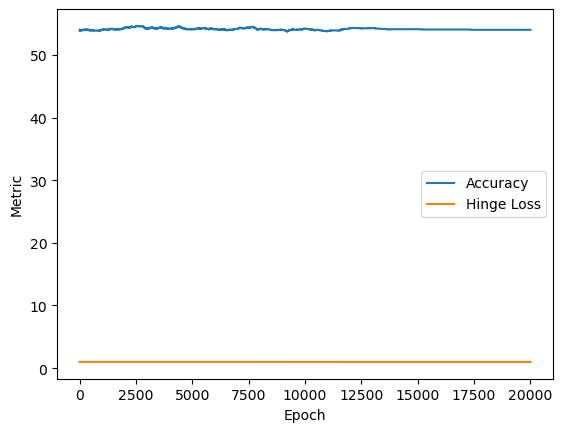

In [668]:
import matplotlib.pyplot as plt

plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()


In [669]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 58.0952380952381


In [670]:
from courselib.models.svm import BinaryKernelSVM
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 0.5)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)
binary_acc


94.89990467111534

In [671]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)
y_train_pred = rbf_svm(X_train)

Test Accuracy: 58.666666666666664


In [672]:
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].replace({-1: 0})
data

Price,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2015-01-30,169.063657,169.370533,23.546528,39.838984,172.828037,165.551780,-0.636618,-0.474056,0.010508,0.009244,-0.012824,-0.013190,0.359100,1
2015-02-02,168.933927,169.300637,28.787086,48.509674,172.510230,165.576446,-0.616104,-0.502466,0.013018,-0.012575,0.009244,-0.012824,0.242203,1
2015-02-03,169.055861,169.469650,34.475864,55.141617,172.744025,165.603219,-0.398475,-0.481667,0.013672,0.012384,-0.012575,0.009244,2.321808,0
2015-02-04,169.166103,169.560526,33.705246,56.060392,172.791604,165.909751,-0.275392,-0.440412,0.011650,0.014461,0.012384,-0.012575,0.818451,1
2015-02-05,169.458962,169.806600,37.648987,63.335882,173.162811,165.856740,-0.038577,-0.360045,0.011753,-0.003808,0.014461,0.012384,0.016739,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.003899,0.004968,0.007824,0.000560,22.609680,0
2025-07-01,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,0.003381,0.004781,0.004968,0.007824,16.746460,1


In [673]:
from courselib.models.glm import LogisticRegression
from courselib.utils.metrics import cross_entropy
training_data_fraction = .8
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign', shuffle=False, return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)
logistic_regression.w, logistic_regression.b

(array([-0.01024074, -0.01032512, -0.01976339, -0.02305074, -0.01390443,
        -0.00605407,  0.0116382 ,  0.0179303 , -0.01954972,  0.01958528,
        -0.01692703, -0.03821349, -0.01387399]),
 array(0.11436452))

In [674]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 56.952380952380956


In [675]:
# Trading Strategy

# Example DataFrame
price = {
    'price': [100, 102, 101, 105, 107, 106],
    'signal': [1, 1, 1, 0, 0, 1]
}

df = pd.DataFrame(price)

# 1. Compute daily asset returns
df['return'] = df['price'].pct_change()

# 2. Shift the signal if needed (optional)
# You might want to execute the trade next day, so shift by 1
df['signal_shifted'] = df['signal'].shift(-1)

# 3. Strategy daily return: asset return * signal
df['strategy_return'] = df['return'] * df['signal_shifted']

# 4. Cumulative returns
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_asset'] = (1 + df['return']).cumprod()

print(df)


   price  signal    return  signal_shifted  strategy_return  \
0    100       1       NaN             1.0              NaN   
1    102       1  0.020000             1.0         0.020000   
2    101       1 -0.009804             0.0        -0.000000   
3    105       0  0.039604             0.0         0.000000   
4    107       0  0.019048             1.0         0.019048   
5    106       1 -0.009346             NaN              NaN   

   cumulative_strategy  cumulative_asset  
0                  NaN               NaN  
1             1.020000              1.02  
2             1.020000              1.01  
3             1.020000              1.05  
4             1.039429              1.07  
5                  NaN              1.06  


In [676]:

def pca_numpy(X: np.ndarray, n_components: int = 2):
    """
    Perform PCA using numpy.

    Parameters:
    -----------
    X : np.ndarray
        The input data matrix, shape (n_samples, n_features).
    n_components : int
        Number of principal components to keep.

    Returns:
    --------
    X_reduced : np.ndarray
        The projected data onto top principal components.
    explained_variance_ratio : np.ndarray
        Percentage of variance explained by each selected component.
    components : np.ndarray
        The eigenvectors (principal axes).
    """
    # 1) Center the data
    X_meaned = X - np.mean(X, axis=0)

    # 2) Covariance matrix
    cov_mat = np.cov(X_meaned, rowvar=False)

    # 3) Eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    # 4) Sort eigenvalues and eigenvectors in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_index]
    eigen_vectors = eigen_vectors[:, sorted_index]

    # 5) Select top k eigenvectors
    eigenvector_subset = eigen_vectors[:, 0:n_components]

    # 6) Project the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # 7) Explained variance ratio
    explained_variance_ratio = eigen_values / np.sum(eigen_values)

    return X_reduced, explained_variance_ratio[:n_components], eigenvector_subset


In [677]:
X_reduced, explained_var, components = pca_numpy(X, n_components=5)
X_reduced, explained_var, components

(array([[ 3.38226167, -0.21337456,  0.21844376,  0.93921826, -1.46617249],
        [ 3.135482  , -0.44446127, -1.76620585, -0.204136  , -0.00877594],
        [ 2.62790752, -0.95800464,  1.61024763,  0.60360724, -0.09843961],
        ...,
        [-5.91375261,  0.96989392, -0.28860226,  0.09046957,  0.24259704],
        [-6.23553319,  0.73619767,  0.22427587,  0.17480485, -0.0758305 ],
        [-5.99422461,  1.02006749, -0.03486111, -0.17681051, -0.53941554]]),
 array([0.34316474, 0.28934193, 0.09415604, 0.08695524, 0.07088648]),
 array([[-0.32569076,  0.3733326 ,  0.01615354, -0.02670621,  0.00844659],
        [-0.32385174,  0.37475023,  0.02096463, -0.03613484,  0.01239067],
        [-0.31904309, -0.31013923,  0.07108674, -0.14755741, -0.02837004],
        [-0.28718325, -0.3044761 ,  0.09262085, -0.20650746,  0.00738644],
        [-0.31224835,  0.38537206,  0.02843082, -0.05057903,  0.0146804 ],
        [-0.3298142 ,  0.36827978,  0.00815033, -0.01026738,  0.00456911],
        [-0.373

In [678]:
split_idx = int(0.8 * len(data))
train_indices = data.index[:split_idx]
test_indices = data.index[split_idx:]
y_train_pred = rbf_svm(X_train)
y_test_pred = rbf_svm(X_test)

raw_data['rbf_svm_pred'] = np.nan
raw_data.loc[train_indices, 'rbf_svm_pred'] = y_train_pred
raw_data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
raw_data
# For another model, e.g. RBF SVM
#data['rbf_svm_pred'] = np.nan
#data.loc[test_indices, 'rbf_svm_pred'] = rbf_y_pred_test  # replace with your variable

# For logistic regression
#data['logreg_pred'] = np.nan
#data.loc[test_indices, 'logreg_pred'] = logreg_y_pred_test  # replace with your variable

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred
Ticker,SPY,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2015-01-30,166.573746,169.063657,169.370533,23.546528,39.838984,172.828037,165.551780,-0.636618,-0.474056,-0.012575,0.010508,0.009244,-0.012824,-0.013190,0.359100,1,1.0
2015-02-02,168.636627,168.933927,169.300637,28.787086,48.509674,172.510230,165.576446,-0.616104,-0.502466,0.012384,0.013018,-0.012575,0.009244,-0.012824,0.242203,1,1.0
2015-02-03,171.075272,169.055861,169.469650,34.475864,55.141617,172.744025,165.603219,-0.398475,-0.481667,0.014461,0.013672,0.012384,-0.012575,0.009244,2.321808,-1,-1.0
2015-02-04,170.423843,169.166103,169.560526,33.705246,56.060392,172.791604,165.909751,-0.275392,-0.440412,-0.003808,0.011650,0.014461,0.012384,-0.012575,0.818451,1,1.0
2015-02-05,172.144302,169.458962,169.806600,37.648987,63.335882,173.162811,165.856740,-0.038577,-0.360045,0.010095,0.011753,-0.003808,0.014461,0.012384,0.016739,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1,1.0
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1,1.0


In [679]:
raw_data['rbf_svm_pred'] = raw_data['rbf_svm_pred'].replace(-1, 0)
raw_data

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred
Ticker,SPY,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2015-01-30,166.573746,169.063657,169.370533,23.546528,39.838984,172.828037,165.551780,-0.636618,-0.474056,-0.012575,0.010508,0.009244,-0.012824,-0.013190,0.359100,1,1.0
2015-02-02,168.636627,168.933927,169.300637,28.787086,48.509674,172.510230,165.576446,-0.616104,-0.502466,0.012384,0.013018,-0.012575,0.009244,-0.012824,0.242203,1,1.0
2015-02-03,171.075272,169.055861,169.469650,34.475864,55.141617,172.744025,165.603219,-0.398475,-0.481667,0.014461,0.013672,0.012384,-0.012575,0.009244,2.321808,-1,0.0
2015-02-04,170.423843,169.166103,169.560526,33.705246,56.060392,172.791604,165.909751,-0.275392,-0.440412,-0.003808,0.011650,0.014461,0.012384,-0.012575,0.818451,1,1.0
2015-02-05,172.144302,169.458962,169.806600,37.648987,63.335882,173.162811,165.856740,-0.038577,-0.360045,0.010095,0.011753,-0.003808,0.014461,0.012384,0.016739,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1,1.0
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1,1.0


In [680]:

raw_data['rbf_svm_pred'] = raw_data['rbf_svm_pred'].shift(-1)
raw_data.tail(5)
raw_data['strategy_return'] = raw_data['Daily_Return'] * raw_data['rbf_svm_pred']
raw_data['cumulative_strategy'] = (1 + raw_data['strategy_return']).cumprod()
raw_data['cumulative_asset'] = (1 + raw_data['Daily_Return']).cumprod()

In [681]:
raw_data.tail(5)

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred,strategy_return,cumulative_strategy,cumulative_asset
Ticker,SPY,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1,1.0,0.004781,2.855683,3.662525
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1,1.0,-0.000324,2.854759,3.661340
2025-07-02,620.450012,605.347306,603.892113,72.221941,71.745537,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,-0.000324,0.004781,0.004968,24.681213,1,1.0,0.004533,2.867700,3.677938
2025-07-03,625.340027,607.064144,605.934772,74.716437,73.148878,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.004533,-0.000324,0.004781,29.661011,-1,1.0,0.007881,2.890302,3.706925
2025-07-07,620.679993,608.311450,607.339079,68.441061,76.277021,626.316802,585.965040,9.821694,8.788578,-0.007452,0.005988,0.007881,0.004533,-0.000324,26.399963,-1,NaN,NaN,NaN,3.679301
